In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_excel('/content/2025 Sports Business & Analytics Night - Hackathon Data Set.xlsx')

In [3]:
## Data Cleaning ##

df=data.copy()
df['onsale'] = pd.to_datetime(df['onsale'], format='%m/%d/%y', errors='coerce')
df['sale_date'] = pd.to_datetime(df['sale_date'], format='%m/%d/%y', errors='coerce')

df['day_of_week'] = df['day_of_week'].str.strip()
df['tier'] = df['tier'].str.strip()
df['event_name'] = df['event_name'].str.strip()

In [4]:
## EDA ##

# Game Level attributes
game_attributes = df[['event_name', 'season', 'tier', 'day_of_week']].drop_duplicates()
game_sales = df.groupby('event_name')['tickets'].sum().reset_index()

games_df = pd.merge(game_sales, game_attributes, on='event_name')

# Excluding target game (so it doesn't skew historicals)
target_game = 'CAV26_25_1102 - Cavaliers vs. Atlanta Hawks'
games_historical = games_df[games_df['event_name'] != target_game]

# Baseline Metrics
total_games = len(games_historical)
avg_tickets = games_historical['tickets'].mean()
games_hitting_goal = (games_historical['tickets'] >= 2500).sum()
pct_hitting_goal = games_hitting_goal / total_games * 100

print("--- HISTORICAL BASELINE METRICS ---")
print(f"Total Historical Games: {total_games}")
print(f"Average Tickets Sold Per Game: {avg_tickets:.0f}")
print(f"Games Hitting 2,500 Goal: {games_hitting_goal} ({pct_hitting_goal:.1f}%)")

tier_avg = games_historical.groupby('tier')['tickets'].mean().round(0).reset_index().sort_values('tier')
print("\n--- AVERAGE TICKETS BY TIER ---")
print(tier_avg.to_string(index=False))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = games_historical.groupby('day_of_week')['tickets'].mean().round(0).reindex(day_order).reset_index()
print("\n--- AVERAGE TICKETS BY DAY OF WEEK ---")
print(day_avg.to_string(index=False))

#games_historical.to_excel('Historical_Games_Summary.xlsx', index=False)

--- HISTORICAL BASELINE METRICS ---
Total Historical Games: 122
Average Tickets Sold Per Game: 2384
Games Hitting 2,500 Goal: 49 (40.2%)

--- AVERAGE TICKETS BY TIER ---
   tier  tickets
 Tier A   2809.0
Tier A+   4108.0
 Tier B   2537.0
 Tier C   2163.0
 Tier D   2255.0
 Tier E   1375.0

--- AVERAGE TICKETS BY DAY OF WEEK ---
day_of_week  tickets
     Monday   2379.0
    Tuesday   2678.0
  Wednesday   2577.0
   Thursday   2028.0
     Friday   2236.0
   Saturday   2525.0
     Sunday   2300.0


Interestingly, midweek games (Tuesday/Wednesday) and Saturdays perform the best historically, averaging over 2,500 tickets. Sundays (the day of your target game) average around 2,300.

 Days_Until_Game  Avg_Cumulative_Pct  Target_Pacing_Tickets
             120            0.034369                   86.0
              60            0.182039                  455.0
              30            0.328585                  821.0
              15            0.474998                 1187.0
              10            0.561668                 1404.0
               0            1.000000                 2500.0


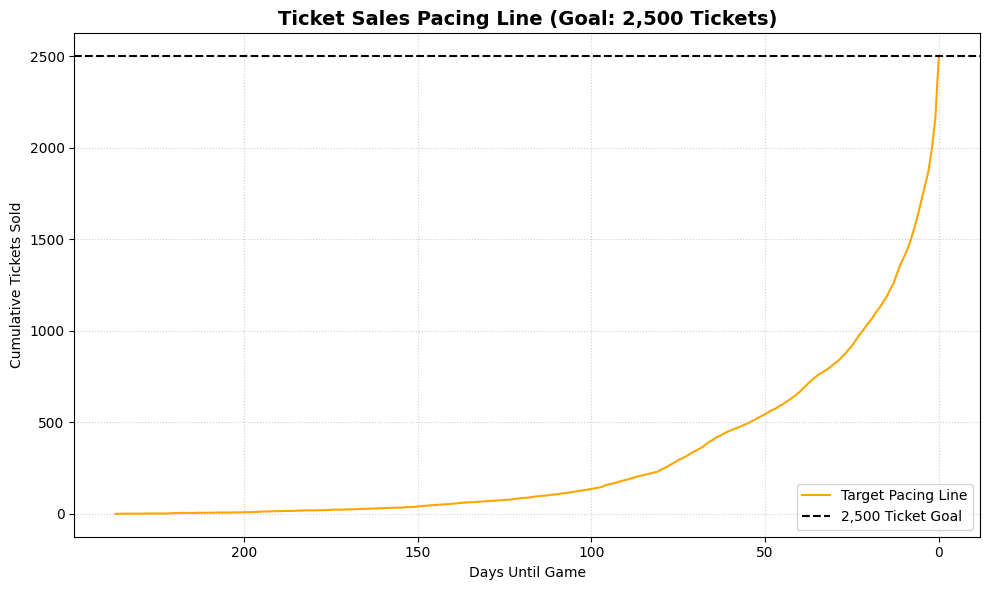

In [5]:
## Building the Pacing Line - "The Standard Curve" ##

target_game = 'CAV26_25_1102 - Cavaliers vs. Atlanta Hawks'
hist_df = df[df['event_name'] != target_game].copy()

daily_sales = hist_df.groupby(['event_name', 'days_until_game'])['tickets'].sum().reset_index()
pivot = daily_sales.pivot(index='event_name', columns='days_until_game', values='tickets').fillna(0)
days_sorted = sorted(pivot.columns, reverse=True)
pivot = pivot[days_sorted]

cum_sales = pivot.cumsum(axis=1) # cumulative sum
final_sales = cum_sales.iloc[:, -1] # last column = total final sales for each game
cum_pct = cum_sales.div(final_sales, axis=0)

avg_cum_pct = cum_pct.mean() # Average Pacing Curve across all historical games
pacing_line = avg_cum_pct * 2500

pacing_df = pd.DataFrame({
    'Days_Until_Game': pacing_line.index,
    'Avg_Cumulative_Pct': avg_cum_pct.values,
    'Target_Pacing_Tickets': pacing_line.values.round(0)
})
#pacing_df.to_excel('Pacing_Line.xlsx', index=False)


plt.figure(figsize=(10, 6))
plt.plot(pacing_df['Days_Until_Game'], pacing_df['Target_Pacing_Tickets'], color='orange', label='Target Pacing Line')
plt.axhline(2500, color='black', linestyle='--', label='2,500 Ticket Goal')
plt.gca().invert_xaxis()

plt.title('Ticket Sales Pacing Line (Goal: 2,500 Tickets)', fontsize=14, fontweight='bold')
plt.xlabel('Days Until Game')
plt.ylabel('Cumulative Tickets Sold')
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#plt.savefig('Pacing_Line.png')

print(pacing_df[pacing_df['Days_Until_Game'].isin([120, 60, 30, 15, 10, 0])].to_string(index=False))

Over 50% of single-game tickets are sold in the final 15 days leading up to tip-off. This proves why we shouldn't panic and slash prices 60 days out just because you only have 500 tickets sold.

Status           Hit Goal (>= 2500)  Missed Goal (< 2500)  Gap (Difference)
days_until_game                                                            
90                            206.0                 141.0              65.0
60                            586.0                 324.0             262.0
45                            774.0                 426.0             347.0
30                           1081.0                 583.0             498.0
15                           1531.0                 856.0             675.0
7                            2038.0                1116.0             922.0
0                            3251.0                1802.0            1448.0


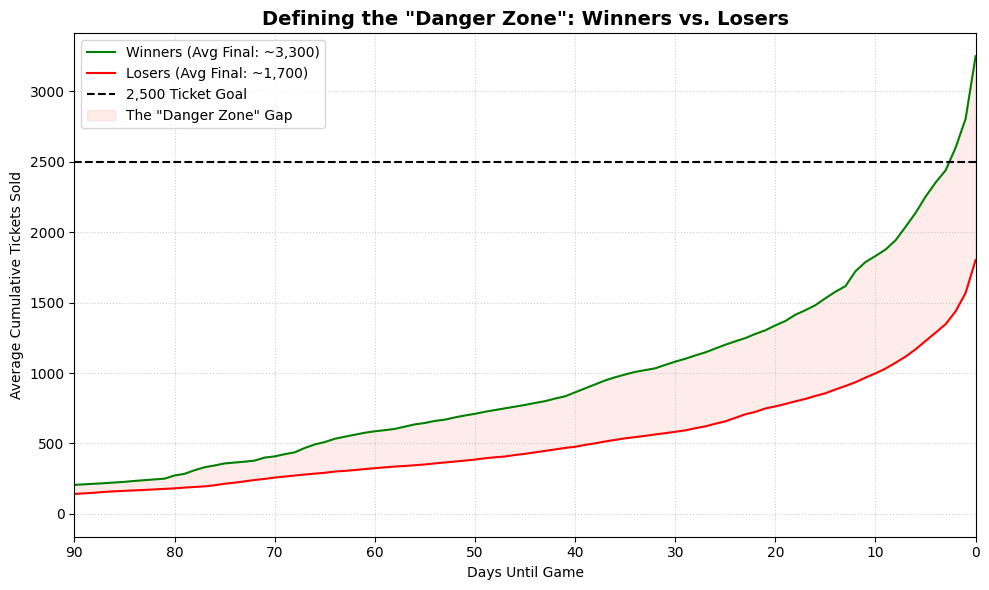

In [6]:
## Defining the "Danger Zone" ##

target_game = 'CAV26_25_1102 - Cavaliers vs. Atlanta Hawks'
hist_df = df[df['event_name'] != target_game].copy()

# Classify games as Winners (hit 2500) or Losers (missed 2500)
game_totals = hist_df.groupby('event_name')['tickets'].sum().reset_index()
game_totals['Status'] = np.where(game_totals['tickets'] >= 2500, 'Hit Goal (>= 2500)', 'Missed Goal (< 2500)')
hist_df = pd.merge(hist_df, game_totals[['event_name', 'Status']], on='event_name')

# daily cumulative sales
daily_sales = hist_df.groupby(['Status', 'event_name', 'days_until_game'])['tickets'].sum().reset_index()
pivot = daily_sales.pivot(index=['Status', 'event_name'], columns='days_until_game', values='tickets').fillna(0)

# Sort days descending and calculate cumulative sum
days_sorted = sorted(pivot.columns, reverse=True)
pivot = pivot[days_sorted]
cum_sales = pivot.cumsum(axis=1)

avg_cum_sales = cum_sales.groupby('Status').mean() # Average cumulative sales by Status


plt.figure(figsize=(10, 6))
plt.plot(avg_cum_sales.columns, avg_cum_sales.loc['Hit Goal (>= 2500)'], color='green', label='Winners (Avg Final: ~3,300)')
plt.plot(avg_cum_sales.columns, avg_cum_sales.loc['Missed Goal (< 2500)'], color='red', label='Losers (Avg Final: ~1,700)')

plt.axhline(2500, color='black', linestyle='--', label='2,500 Ticket Goal')

plt.gca().invert_xaxis()
plt.xlim(90, 0) # Focus on the last 90 days where the action happens
plt.title('Defining the "Danger Zone": Winners vs. Losers', fontsize=14, fontweight='bold')
plt.xlabel('Days Until Game')
plt.ylabel('Average Cumulative Tickets Sold')

plt.fill_between(avg_cum_sales.columns, avg_cum_sales.loc['Hit Goal (>= 2500)'], avg_cum_sales.loc['Missed Goal (< 2500)'], color='salmon', alpha=0.15, label='The "Danger Zone" Gap')

plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#plt.savefig('Danger_Zone.png')

milestones = [90, 60, 45, 30, 15, 7, 0]
comparison = avg_cum_sales[milestones].T
comparison['Gap (Difference)'] = comparison['Hit Goal (>= 2500)'] - comparison['Missed Goal (< 2500)']
print(comparison.round(0))

From the data table output:
- At 90 days out, the difference between a hit and a miss is only 65 tickets. That is statistical noise. It is too early to panic.
- At 60 days out, the gap widens to ~260 tickets.
- At 30 days out, the "Losers" are only at ~580 tickets, while the Winners are already past 1,000. This is the point of no return. If you wait until 15 days out to intervene, you are already almost 700 tickets behind, and it is impossible to catch up without gutting your ticket prices.

**Recommendation:**

You can structure your hackathon pitch with these exact, data-backed triggers:
- The Yellow Alert (45 Days Out): If cumulative sales are below 600 tickets, trigger "Soft Interventions" (value-adds, no discounts).
- The Red Alert (30 Days Out): If cumulative sales are below 850 tickets, trigger "Hard Interventions" (aggressive targeted campaigns, volume bundling).

**Interventions (Without Slashing Prices):**
- The "Value-Add" Bundle (Trigger: 45 Days Out)
- Action: Instead of discounting a \$50 ticket to \$35 (losing \$15), keep the ticket at \$50 but throw in a \$15 food/beverage credit or a free team beanie.
- Why it works: The perceived value to the fan is \$15, but the actual cost to the Cavs for a hotdog/soda is maybe \$3. You protect your ticketing revenue while driving urgency.

**Family Packs (Trigger: 30 Days Out):**
- Action: Target local youth basketball leagues or schools with a "4-Pack" offer.
- Why it works: You are generating bulk ticket sales (4 tickets per transaction instead of 2) without lowering the advertised single-game price for the general public.

**The Scarcity/Access Play (Trigger: 15 Days Out);**
- Action: Launch a campaign: "Buy a ticket to Sunday's game vs. the Hawks and get early presale access to the upcoming game vs. the Lakers (Tier A+)."
- Why it works: You are using the immense demand of a Tier A+ game to subsidize the weak demand of a Tier D game.

Target Game: CAV26_25_1102 - Cavaliers vs. Atlanta Hawks
Current Total Tickets Sold: 398
Current Days Until Game: 20
Expected % of final sales at 20 days out (Tier D): 42.09%
Projected Final Sales: 946


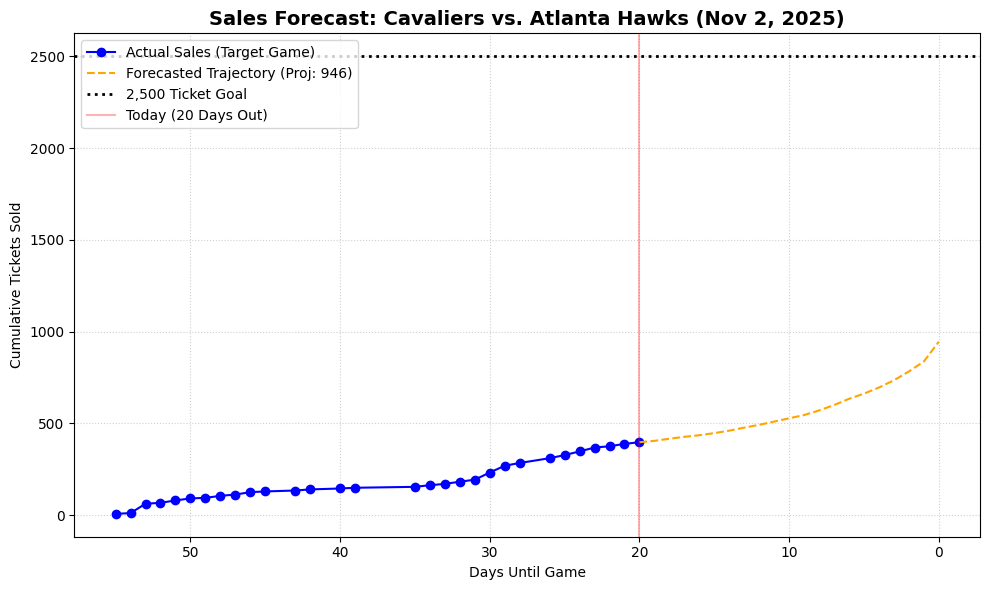

In [7]:
## Forecasting the November 2, 2025 Game ##

target_game_name = 'CAV26_25_1102 - Cavaliers vs. Atlanta Hawks'
target_game_df = df[df['event_name'] == target_game_name]

current_sales = target_game_df['tickets'].sum()
current_days_out = target_game_df['days_until_game'].min()

print(f"Target Game: {target_game_name}")
print(f"Current Total Tickets Sold: {current_sales}")
print(f"Current Days Until Game: {current_days_out}")

# pacing curve specifically for Tier D games
hist_df = df[df['event_name'] != target_game_name].copy()
tier_d_df = hist_df[hist_df['tier'] == 'Tier D']

tier_d_avg_final = tier_d_df.groupby('event_name')['tickets'].sum().mean()

# daily cumulative sales for Tier D
daily_sales = tier_d_df.groupby(['event_name', 'days_until_game'])['tickets'].sum().reset_index()
pivot = daily_sales.pivot(index='event_name', columns='days_until_game', values='tickets').fillna(0)
days_sorted = sorted(pivot.columns, reverse=True)
pivot = pivot[days_sorted]
cum_sales = pivot.cumsum(axis=1)

final_sales = cum_sales.iloc[:, -1]
cum_pct = cum_sales.div(final_sales, axis=0)
tier_d_avg_pct = cum_pct.mean()

# expected percentage at the current_days_out
expected_pct_now = tier_d_avg_pct.get(current_days_out, 0)
print(f"Expected % of final sales at {current_days_out} days out (Tier D): {expected_pct_now:.2%}")

# Predict final sales based on Tier D pacing
if expected_pct_now > 0:
    projected_final = current_sales / expected_pct_now
else:
    projected_final = current_sales

print(f"Projected Final Sales: {projected_final:.0f}")

# forecast curve
forecast_days = [d for d in days_sorted if d <= current_days_out]
forecast_pcts = [tier_d_avg_pct.get(d, 0) for d in forecast_days]
# future sales based on the projected final
forecast_sales = [projected_final * pct for pct in forecast_pcts]


plt.figure(figsize=(10, 6))

# Target Game Actual Sales (Past)
actual_daily = target_game_df.groupby('days_until_game')['tickets'].sum().reset_index()
actual_daily = actual_daily.sort_values('days_until_game', ascending=False)
actual_daily['cum_tickets'] = actual_daily['tickets'].cumsum()

plt.plot(actual_daily['days_until_game'], actual_daily['cum_tickets'], color='blue', marker='o', label='Actual Sales (Target Game)')

# Target Game Forecast (Future)
plt.plot(forecast_days, forecast_sales, color='orange', linestyle='--', label=f'Forecasted Trajectory (Proj: {projected_final:.0f})')

plt.axhline(2500, color='black', linestyle=':', linewidth=2, label='2,500 Ticket Goal')

plt.axvline(current_days_out, color='red', linestyle='-', alpha=0.3, label='Today (20 Days Out)')

plt.gca().invert_xaxis()
plt.title('Sales Forecast: Cavaliers vs. Atlanta Hawks (Nov 2, 2025)', fontsize=14, fontweight='bold')
plt.xlabel('Days Until Game')
plt.ylabel('Cumulative Tickets Sold')
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
#plt.savefig('Forecast_Hawks_Game.png')

We are currently 20 days out from the game. Here is the exact snapshot:
- Current Tickets Sold: 398
- The "Standard" Pacing: Historically, a Tier D game has sold about 42.1% of its total tickets by the 20-day mark.
- The Projection: If we divide the 398 current tickets by that 42.1% completion rate, the model projects this game will finish with only 946 total tickets sold.

This is a CODE RED. The game is projected to miss the 2,500 ticket goal by over 1,500 tickets. It has officially triggered the "Red Alert Danger Zone" we defined in Phase 3. The pacing is drastically behind even a historically "bad" game.

In [8]:
## Forecast Sales for Tableau ##

target_game_name = 'CAV26_25_1102 - Cavaliers vs. Atlanta Hawks'

target_df = df[df['event_name'] == target_game_name]
actual_daily = target_df.groupby('days_until_game')['tickets'].sum().reset_index()
actual_daily = actual_daily.sort_values('days_until_game', ascending=False)
actual_daily['Actual_Sales'] = actual_daily['tickets'].cumsum()

current_days_out = actual_daily['days_until_game'].min()
current_sales = actual_daily['Actual_Sales'].max()

# forecast calculation (Tier D Pacing)
hist_df = df[df['event_name'] != target_game_name]
tier_d_df = hist_df[hist_df['tier'] == 'Tier D']

# Tier D Pacing Curve
tier_d_daily = tier_d_df.groupby(['event_name', 'days_until_game'])['tickets'].sum().reset_index()
pivot = tier_d_daily.pivot(index='event_name', columns='days_until_game', values='tickets').fillna(0)
days_sorted = sorted(pivot.columns, reverse=True)
pivot = pivot[days_sorted]
cum_sales = pivot.cumsum(axis=1)

final_sales = cum_sales.iloc[:, -1]
cum_pct = cum_sales.div(final_sales, axis=0)
tier_d_avg_pct = cum_pct.mean()

expected_pct_now = tier_d_avg_pct.get(current_days_out, 0)
projected_final = current_sales / expected_pct_now if expected_pct_now > 0 else current_sales

# Create Forecast Dataframe
forecast_data = []
for d in days_sorted:
    if d <= current_days_out:
        pct = tier_d_avg_pct.get(d, 0)
        forecast_data.append({'days_until_game': d, 'Forecasted_Sales': round(projected_final * pct, 0)})

forecast_df = pd.DataFrame(forecast_data)

final_chart_df = pd.merge(pd.DataFrame({'days_until_game': days_sorted}), actual_daily[['days_until_game', 'Actual_Sales']], on='days_until_game', how='left')
final_chart_df = pd.merge(final_chart_df, forecast_df, on='days_until_game', how='left')

final_chart_df = final_chart_df.dropna(subset=['Actual_Sales', 'Forecasted_Sales'], how='all')

final_chart_df.head(15)
#final_chart_df.to_excel('Hawks_Forecast_Chart_Data.xlsx', index=False)

,days_until_game,Actual_Sales,Forecasted_Sales
170,55,8.0,NaN
171,54,12.0,NaN
172,53,63.0,NaN
173,52,68.0,NaN
174,51,81.0,NaN
175,50,92.0,NaN
176,49,95.0,NaN
177,48,106.0,NaN
178,47,113.0,NaN
179,46,126.0,NaN
